In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import xgboost as xgb
import lightgbm as lgb
#import catboost as cb

In [3]:
# Load preprocessed data
df = pd.read_csv('processed_iot_sensor_data.csv', parse_dates=['timestamp'])

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Preview the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431941 entries, 2024-12-01 00:59:00 to 2024-12-30 23:59:00
Data columns (total 48 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   temperature                   431941 non-null  float64
 1   vibration                     431941 non-null  float64
 2   pressure                      431941 non-null  float64
 3   humidity                      431941 non-null  float64
 4   failure                       431941 non-null  int64  
 5   machine_id                    431941 non-null  int64  
 6   temperature_lag_1             431941 non-null  float64
 7   temperature_lag_2             431941 non-null  float64
 8   temperature_lag_3             431941 non-null  float64
 9   vibration_lag_1               431941 non-null  float64
 10  vibration_lag_2               431941 non-null  float64
 11  vibration_lag_3               431941 non-null  float64
 12  pressure_l

In [15]:
# Load the preprocessed dataset
df = pd.read_csv('processed_iot_sensor_data.csv', parse_dates=['timestamp'])

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Preview the data
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431941 entries, 2024-12-01 00:59:00 to 2024-12-30 23:59:00
Data columns (total 48 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   temperature                   431941 non-null  float64
 1   vibration                     431941 non-null  float64
 2   pressure                      431941 non-null  float64
 3   humidity                      431941 non-null  float64
 4   failure                       431941 non-null  int64  
 5   machine_id                    431941 non-null  int64  
 6   temperature_lag_1             431941 non-null  float64
 7   temperature_lag_2             431941 non-null  float64
 8   temperature_lag_3             431941 non-null  float64
 9   vibration_lag_1               431941 non-null  float64
 10  vibration_lag_2               431941 non-null  float64
 11  vibration_lag_3               431941 non-null  float64
 12  pressure_l

In [16]:
# Select only the sensor columns for predictive modeling
sensor_columns = ['temperature', 'vibration', 'pressure', 'humidity']

# Create lag features (shifted versions of the columns)
for col in sensor_columns:
    for lag in range(1, 4):  # Create 3 lag features for each column
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# Create rolling window features (moving averages, standard deviations, etc.)
window_size = 5
for col in sensor_columns:
    df[f'{col}_rolling_mean'] = df[col].rolling(window=window_size).mean()
    df[f'{col}_rolling_std'] = df[col].rolling(window=window_size).std()

# Drop rows with NaN values caused by lags and rolling windows
df.dropna(inplace=True)

# Generate synthetic failure labels (1 = failure, 0 = normal) 
# For example, randomly assign 2% of the data as "failures"
np.random.seed(42)
df['failure'] = np.random.choice([0, 1], size=len(df), p=[0.98, 0.02])

# Check the class distribution
print(df['failure'].value_counts())

failure
0    423345
1      8592
Name: count, dtype: int64


In [17]:
# Separate features (X) and target (y)
X = df.drop(['failure'], axis=1)
y = df['failure']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training set: {X_train.shape}, Test set: {X_test.shape}')


Training set: (345549, 47), Test set: (86388, 47)


In [18]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
print("XGBoost Classification Report")
print(classification_report(y_test, y_pred))


XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     84670
           1       0.00      0.00      0.00      1718

    accuracy                           0.98     86388
   macro avg       0.49      0.50      0.49     86388
weighted avg       0.96      0.98      0.97     86388



C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [19]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lgb_model.predict(X_test)

# Evaluation metrics
print("LightGBM Classification Report")
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 6874, number of negative: 338675
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.339856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10295
[LightGBM] [Info] Number of data points in the train set: 345549, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019893 -> initscore=-3.897295
[LightGBM] [Info] Start training from score -3.897295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape data for LSTM (samples, timesteps, features)
X_reshaped = X.values.reshape((X.shape[0], 1, X.shape[1]))

# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_reshaped, y, epochs=10, batch_size=32, validation_split=0.2)


C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 115s 10ms/step - accuracy: 0.9798 - loss: 0.1089 - val_accuracy: 0.9802 - val_loss: 0.0974
Epoch 2/10
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 100s 9ms/step - accuracy: 0.9800 - loss: 0.0991 - val_accuracy: 0.9802 - val_loss: 0.0976
Epoch 3/10
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 118s 11ms/step - accuracy: 0.9799 - loss: 0.0993 - val_accuracy: 0.9802 - val_loss: 0.0975
Epoch 4/10
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 112s 10ms/step - accuracy: 0.9800 - loss: 0.0991 - val_accuracy: 0.9802 - val_loss: 0.0992
Epoch 5/10
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 109s 10ms/step - accuracy: 0.9800 - loss: 0.0988 - val_accuracy: 0.9802 - val_loss: 0.0975
Epoch 6/10
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 101s 9ms/step - accuracy: 0.9801 - loss: 0.0982 - val_accuracy: 0.9802 - val_loss: 0.0974
Epoch 7/10
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 91s 8ms/step - accuracy: 0.9801 - loss: 0.0982 - val_accuracy: 0.9802 - val_loss: 0.0975
Epoch 8/10
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - 

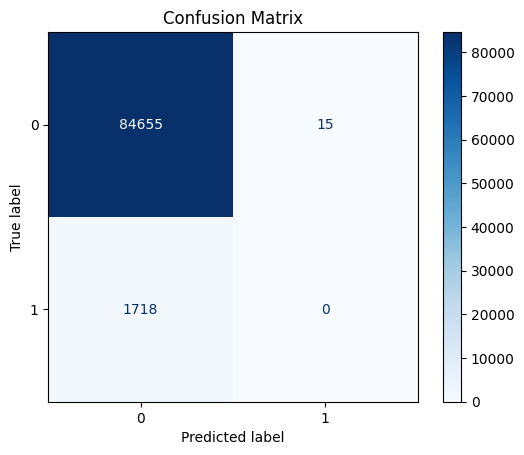

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [23]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model again on the resampled dataset
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_resampled, y_resampled)

y_pred = xgb_model.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[[84655    15]
 [ 1718     0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     84670
           1       0.00      0.00      0.00      1718

    accuracy                           0.98     86388
   macro avg       0.49      0.50      0.49     86388
weighted avg       0.96      0.98      0.97     86388



In [24]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                              scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
                              random_state=42)
xgb_model.fit(X_train, y_train)


C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [32]:
# Predict probabilities instead of hard class predictions
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Change classification threshold to 0.3 instead of 0.5
y_pred_custom_threshold = (y_probs >= 0.3).astype(int)

# Confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_custom_threshold))
print(classification_report(y_test, y_pred_custom_threshold))


[[ 3059 81611]
 [   63  1655]]
              precision    recall  f1-score   support

           0       0.98      0.04      0.07     84670
           1       0.02      0.96      0.04      1718

    accuracy                           0.05     86388
   macro avg       0.50      0.50      0.05     86388
weighted avg       0.96      0.05      0.07     86388



In [26]:
# Create lag features for previous 3 time steps
for col in sensor_columns:
    for lag in range(1, 4):
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# Rolling windows (mean, std, kurtosis, skewness)
window_size = 5
for col in sensor_columns:
    df[f'{col}_rolling_mean'] = df[col].rolling(window=window_size).mean()
    df[f'{col}_rolling_std'] = df[col].rolling(window=window_size).std()
    df[f'{col}_rolling_skew'] = df[col].rolling(window=window_size).skew()
    df[f'{col}_rolling_kurtosis'] = df[col].rolling(window=window_size).kurt()

df.dropna(inplace=True)


100%|===================| 86030/86388 [04:05<00:01]        

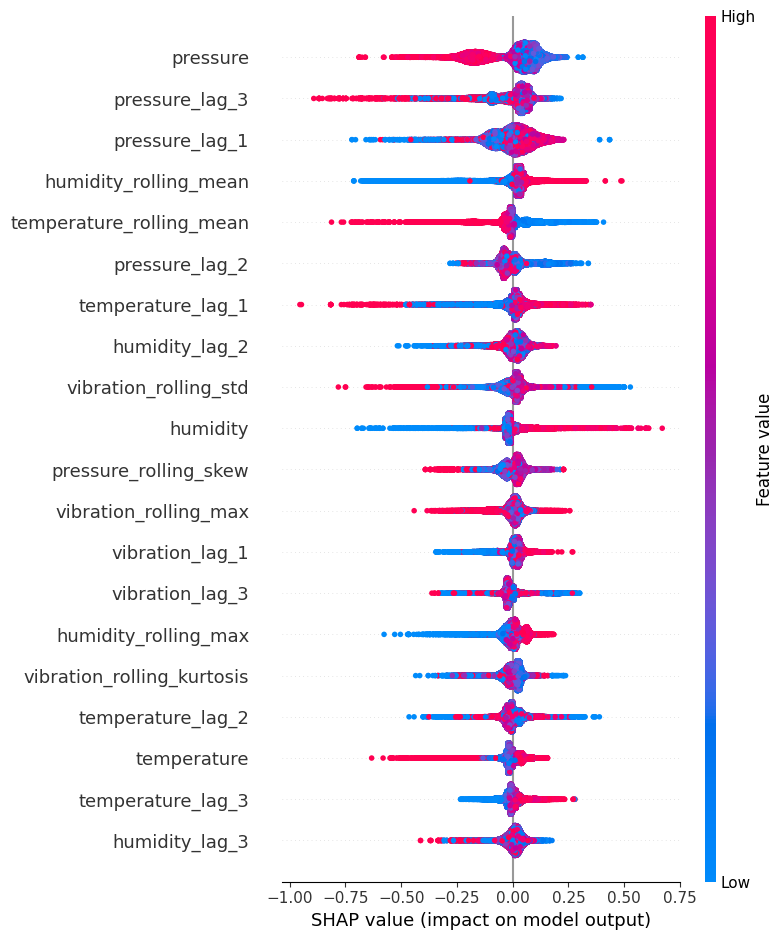

In [30]:
import shap

# Explain predictions with SHAP values
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)

# Visualize the most important features
shap.summary_plot(shap_values, X_test)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape input for LSTM (samples, timesteps, features)
X_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM model
history = model.fit(X_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)


C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8639/8639 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - accuracy: 0.9789 - loss: 0.1097 - val_accuracy: 0.9802 - val_loss: 0.0974
Epoch 2/10
8639/8639 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9802 - loss: 0.0987 - val_accuracy: 0.9802 - val_loss: 0.0972
Epoch 3/10
8639/8639 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9802 - loss: 0.0988 - val_accuracy: 0.9802 - val_loss: 0.0975
Epoch 4/10
8639/8639 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9807 - loss: 0.0964 - val_accuracy: 0.9802 - val_loss: 0.0975
Epoch 5/10
8639/8639 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9802 - loss: 0.0981 - val_accuracy: 0.9802 - val_loss: 0.0973
Epoch 6/10
8639/8639 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.9798 - loss: 0.0995 - val_accuracy: 0.9802 - val_loss: 0.0974
Epoch 7/10
8639/8639 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.9803 - loss: 0.0977 - val_accuracy: 0.9802 - val_loss: 0.0973
Epoch 8/10
8639/8639 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.9801 - loss: 0